In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('custom_modules')

import Data_processing as dp

from IPython.display import display
from matplotlib import ticker
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Пути к X части выборки с массивами в каждой ячейке
path_to_array_like_X_data = ('data/Prepared data/Run1/X_data_array_like.xlsx',
                             'data/Prepared data/Run2/X_data_array_like.xlsx')
# Пути к Y части выборки
path_to_Y_data = ('data/Prepared data/Run1/Y_data(binary_classification).xlsx', 
                  'data/Prepared data/Run2/Y_data(binary_classification).xlsx') 


### Константы для обработки данных

In [3]:
PREP_image_size = 64
PREP_crop_step = 32

In [4]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

# Подготовка данных

In [5]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

for i,x_data_path,y_data_path in zip(range(len(path_to_array_like_X_data)),
                                     path_to_array_like_X_data, 
                                     path_to_Y_data):
    
    x_temp = dp.get_array_like_X_df(x_data_path)
    y_temp = dp.get_Y_df(y_data_path)
    
    
    
    X_dict[f'run{i+1}'] = {'df' : x_temp}
    Y_dict[f'run{i+1}'] = {'df' : y_temp}

In [6]:
print('Загружены данные для X выборки из файлов: ', X_dict.keys())
print('Загружены данные для Y выборки из файлов: ', Y_dict.keys())

Загружены данные для X выборки из файлов:  dict_keys(['run1', 'run2'])
Загружены данные для Y выборки из файлов:  dict_keys(['run1', 'run2'])


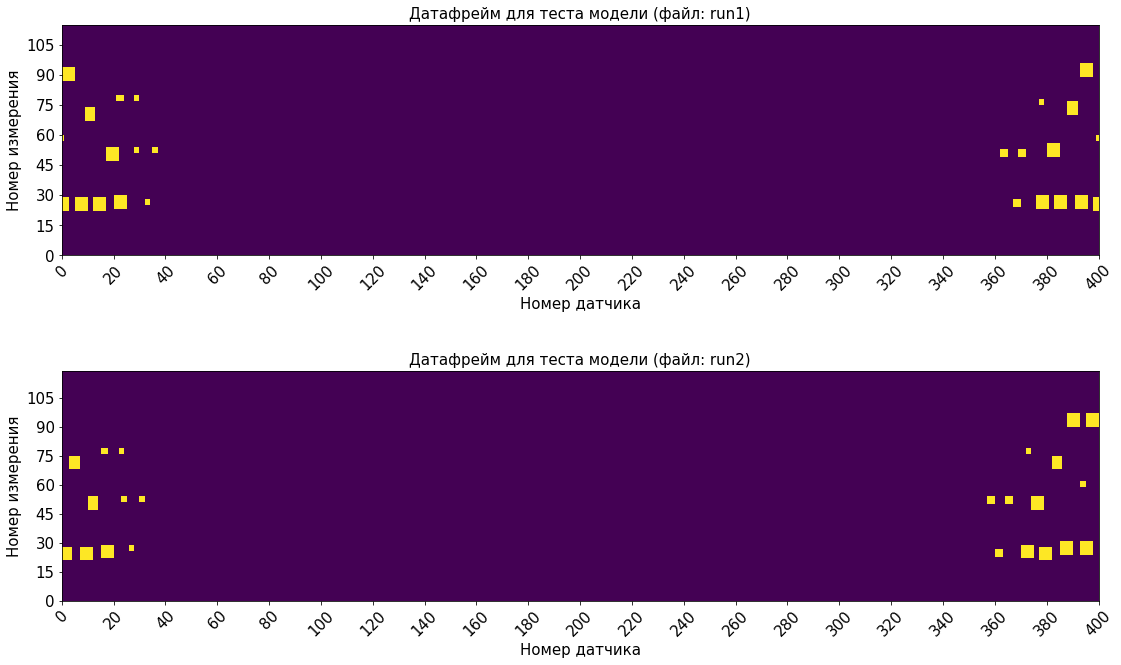

In [9]:
fig, axes = plt.subplots(2)

fig.set_figwidth(18)
fig.set_figheight(10)

for ax,key in zip(axes,Y_dict.keys()):
    ax.pcolormesh(Y_dict[key]['df'])

    ax.set_xlabel('Номер датчика', fontsize=15) 
    ax.set_ylabel('Номер измерения', fontsize=15) 
    ax.set_title(f'Датафрейм для теста модели (файл: {key})', fontsize=15) 

    #  Устанавливаем интервал основных делений: 
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
    ax.yaxis.set_major_locator(ticker.MultipleLocator(15)) 

    #  Устанавливаем форматирование чисел основных делений: 
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 

    #  Устанавливаем форматирование делений: 
    ax.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
    ax.yaxis.set_tick_params(which = 'major', labelsize = 15)
     
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.5)
plt.show()

In [8]:
# добавление строк в датафреймы
for i,key in zip(range(len(X_dict.keys())),X_dict.keys()):
    print(f"||||||||||| step:  {i} |||||||||||")
    print('||||||||||| X df preprocessing |||||||||||')
    X_dict[key]['df'] = dp.reshape_df_for_future_crops(X_dict[key]['df'], 
                                                                PREP_image_size, 
                                                                PREP_crop_step)
    print('||||||||||| Y df preprocessing |||||||||||')
    Y_dict[key]['df'] = dp.reshape_df_for_future_crops(Y_dict[key]['df'], 
                                                                PREP_image_size, 
                                                                PREP_crop_step) 


    print('\n')

||||||||||| step:  0 |||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  32
New df shape:  (128, 416)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  32
New df shape:  (128, 416)
||||||||||||||||||



||||||||||| step:  1 |||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (119, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  32
New df shape:  (128, 416)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (119, 400)
Crop wind

In [9]:
# запишем в словарь numpy array полученные из df
for i,key in zip(range(len(X_dict.keys())),X_dict.keys()):
    print(f"|||||||||||||| step: {i+1}||||||||||||||||")
    print(f"|||||||||||||| file: {key}||||||||||||||||")

    print('||||||||||| X df preprocessing |||||||||||')
    x_time_temp, \
    x_amp_temp = dp.reshape_X_df_to_image_like_numpy(X_dict[key]['df'], 
                                                        PREP_image_size, 
                                                        PREP_crop_step)
    X_dict[key]['X_time_all'] = x_time_temp
    X_dict[key]['X_amp_all'] = x_amp_temp

    print('||||||||||| Y df preprocessing |||||||||||')
    y_temp = dp.reshape_Y_df_to_image_like_numpy(Y_dict[key]['df'], 
                                                 PREP_image_size, 
                                                 PREP_crop_step)
    Y_dict[key]['Y_mask_all'] = y_temp
        
    print('\n')
    
    

|||||||||||||| step: 1||||||||||||||||
|||||||||||||| file: run1||||||||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (128, 416)
Crop windows height/width:  64
New X_time shape:  (36, 64, 64, 32)
New X_amp shape:  (36, 64, 64, 32)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Y df reshaping to 3D
Original df size:  (128, 416)
Crop windows height/width:  64
New numpy shape:  (36, 64, 64, 1)
||||||||||||||||||



|||||||||||||| step: 2||||||||||||||||
|||||||||||||| file: run2||||||||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (128, 416)
Crop windows height/width:  64
New X_time shape:  (36, 64, 64, 32)
New X_amp shape:  (36, 64, 64, 32)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Y df reshaping to 3D
Original df size:  (128, 416)
Crop windows height/width:  64
New numpy shape:  (36, 6

In [10]:
print('||||||||||||||||||||||||||||')
print('Данные считаны для файлов: ',X_dict.keys())
print('\n||||||||||| X data |||||||||||')
for key in X_dict.keys():
    print(f'Для файла \"{key}\" для \"X\" выборки считано ', X_dict[key].keys())

print('\n||||||||||| Y data |||||||||||')        
for key in Y_dict.keys():
    print(f'Для файла \"{key}\" для \"Y\" выборки считано ', Y_dict[key].keys())

||||||||||||||||||||||||||||
Данные считаны для файлов:  dict_keys(['run1', 'run2'])

||||||||||| X data |||||||||||
Для файла "run1" для "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all'])
Для файла "run2" для "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all'])

||||||||||| Y data |||||||||||
Для файла "run1" для "Y" выборки считано  dict_keys(['df', 'Y_mask_all'])
Для файла "run2" для "Y" выборки считано  dict_keys(['df', 'Y_mask_all'])


In [11]:
# обработка данных
for i,key in zip(range(len(X_dict.keys())),X_dict.keys()):
    print(f"|||||||||||||| step: {i+1}||||||||||||||||")
    print(f"|||||||||||||| file: {key}||||||||||||||||")

    print('||||||||||| X df preprocessing |||||||||||')

    (X_time_def, X_time_non_def), \
    (X_amp_def, X_amp_non_def), \
    (Y_mask_def, Y_mask_non_def), \
    (Y_binary_def, Y_binary_non_def) = dp.preprocess_data(X_dict[key]['X_time_all'], 
                                                                    X_dict[key]['X_amp_all'], 
                                                                    Y_dict[key]['Y_mask_all'],
                                                                    PREP_image_size)

    X_dict[key]['X_time_def'] = X_time_def
    X_dict[key]['X_time_non_def'] = X_time_non_def

    X_dict[key]['X_amp_def'] = X_amp_def
    X_dict[key]['X_amp_non_def'] = X_amp_non_def

    Y_dict[key]['Y_mask_def'] = Y_mask_def
    Y_dict[key]['Y_mask_non_def'] = Y_mask_non_def

    Y_dict[key]['Y_binary_def'] = Y_binary_def
    Y_dict[key]['Y_binary_non_def'] = Y_binary_non_def

|||||||||||||| step: 1||||||||||||||||
|||||||||||||| file: run1||||||||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Data preprocessing
Orig X_time shape:  (36, 64, 64, 32)
Orig X_amp shape:  (36, 64, 64, 32)
Orig Y_mask shape:  (36, 64, 64, 1)
||||||||||||||||||
Data standartization
X_time_max: 44.5
X_amp_max: 62.992

X_time_max after standartization: 1.0
X_time_min after standartization: 0.0

X_amp_max after standartization: 1.0
X_amp_min after standartization: -0.983743967487935
||||||||||||||||||

||||||||||||||||||
Data with and witout defects splitting
||||||||||||||||||
Defects nums calculating
Для карт высотой и шириной в 64
и общим кличеством: 36
дефекты присутствуеют на 11 картах
||||||||||||||||||

X_time_def shape:  (11, 64, 64, 32)
X_time_non_def shape:  (25, 64, 64, 32)

X_amp_def shape:  (11, 64, 64, 32)
X_amp_non_def shape:  (25, 64, 64, 32)

Y_mask_def shape:  (11, 64, 64, 1)
Y_mask_non_def shape:  (25, 64, 64, 1)

Y_binary_def shape:  (11,)
Y

In [12]:
print('||||||||||||||||||||||||||||')
print('Данные считаны для файлов: ',X_dict.keys())
print('\n||||||||||| X data |||||||||||')
for key in X_dict.keys():
    print(f'Для файла \"{key}\" для \"X\" выборки считано ', X_dict[key].keys())

print('\n||||||||||| Y data |||||||||||')        
for key in Y_dict.keys():
    print(f'Для файла \"{key}\" для \"Y\" выборки считано ', Y_dict[key].keys())

||||||||||||||||||||||||||||
Данные считаны для файлов:  dict_keys(['run1', 'run2'])

||||||||||| X data |||||||||||
Для файла "run1" для "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])
Для файла "run2" для "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])

||||||||||| Y data |||||||||||
Для файла "run1" для "Y" выборки считано  dict_keys(['df', 'Y_mask_all', 'Y_mask_def', 'Y_mask_non_def', 'Y_binary_def', 'Y_binary_non_def'])
Для файла "run2" для "Y" выборки считано  dict_keys(['df', 'Y_mask_all', 'Y_mask_def', 'Y_mask_non_def', 'Y_binary_def', 'Y_binary_non_def'])


In [13]:
# обработка данных
for key in X_dict.keys():
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    print('X_time_def.shape: ', X_dict[key]['X_time_def'].shape)
    print('X_amp_def.shape: ', X_dict[key]['X_amp_def'].shape)
    print('Y_mask_def.shape: ', Y_dict[key]['Y_mask_def'].shape)
    print('Y_binary_def.shape: ', Y_dict[key]['Y_binary_def'].shape)
    print()
    print('X_time_non_def.shape: ', X_dict[key]['X_time_non_def'].shape)
    print('X_amp_non_def.shape: ', X_dict[key]['X_amp_non_def'].shape)
    print('Y_mask_non_def.shape: ', Y_dict[key]['Y_mask_non_def'].shape)
    print('Y_binary_non_def.shape: ', Y_dict[key]['Y_binary_non_def'].shape)
    print()

|||||||||||||| file: run1||||||||||||||||
X_time_def.shape:  (11, 64, 64, 32)
X_amp_def.shape:  (11, 64, 64, 32)
Y_mask_def.shape:  (11, 64, 64, 1)
Y_binary_def.shape:  (11,)

X_time_non_def.shape:  (25, 64, 64, 32)
X_amp_non_def.shape:  (25, 64, 64, 32)
Y_mask_non_def.shape:  (25, 64, 64, 1)
Y_binary_non_def.shape:  (25,)

|||||||||||||| file: run2||||||||||||||||
X_time_def.shape:  (9, 64, 64, 32)
X_amp_def.shape:  (9, 64, 64, 32)
Y_mask_def.shape:  (9, 64, 64, 1)
Y_binary_def.shape:  (9,)

X_time_non_def.shape:  (27, 64, 64, 32)
X_amp_non_def.shape:  (27, 64, 64, 32)
Y_mask_non_def.shape:  (27, 64, 64, 1)
Y_binary_non_def.shape:  (27,)



In [14]:
X_time_test_1 = np.concatenate([X_dict['run1']['X_time_def'],
                                X_dict['run1']['X_time_non_def']],axis=0)
X_amp_test_1 = np.concatenate([X_dict['run1']['X_amp_def'],
                               X_dict['run1']['X_amp_non_def']],axis=0)
Y_mask_test_1 = np.concatenate([Y_dict['run1']['Y_mask_def'],
                                Y_dict['run1']['Y_mask_non_def']],axis=0)
Y_binary_test_1 = np.concatenate([Y_dict['run1']['Y_binary_def'],
                                  Y_dict['run1']['Y_binary_non_def']],axis=0)

X_time_test_2 = np.concatenate([X_dict['run2']['X_time_def'],
                                X_dict['run2']['X_time_non_def']],axis=0)
X_amp_test_2 = np.concatenate([X_dict['run2']['X_amp_def'],
                               X_dict['run2']['X_amp_non_def']],axis=0)
Y_mask_test_2 = np.concatenate([Y_dict['run2']['Y_mask_def'],
                                Y_dict['run2']['Y_mask_non_def']],axis=0)
Y_binary_test_2 = np.concatenate([Y_dict['run2']['Y_binary_def'],
                                  Y_dict['run2']['Y_binary_non_def']],axis=0)

In [15]:
print('X_time_test_1.shape: ', X_time_test_1.shape)
print('X_amp_test_1.shape: ', X_amp_test_1.shape)
print('Y_mask_test_1.shape', Y_mask_test_1.shape)
print('Y_binary_test_1.shape', Y_binary_test_1.shape)
print('\n')

print('X_time_test_2.shape: ', X_time_test_2.shape)
print('X_amp_test_2.shape: ', X_amp_test_2.shape)
print('Y_mask_test_2.shape', Y_mask_test_2.shape)
print('Y_binary_test_2.shape', Y_binary_test_2.shape)
print('\n')

X_time_test_1.shape:  (36, 64, 64, 32)
X_amp_test_1.shape:  (36, 64, 64, 32)
Y_mask_test_1.shape (36, 64, 64, 1)
Y_binary_test_1.shape (36,)


X_time_test_2.shape:  (36, 64, 64, 32)
X_amp_test_2.shape:  (36, 64, 64, 32)
Y_mask_test_2.shape (36, 64, 64, 1)
Y_binary_test_2.shape (36,)




In [16]:
model = keras.models.load_model('Networks//CNN//NetWork_(64x32+64x32)_to(1)_0dot0000006.h5')

In [17]:
# тест модели
model.evaluate([X_time_test_1,X_amp_test_1], Y_binary_test_1, batch_size = 1)

36/36 [==============================] - 2s 53ms/step - loss: 0.3047


0.30468758940696716

In [18]:
# тест модели
model.evaluate([X_time_test_2,X_amp_test_2], Y_binary_test_2, batch_size = 1)

36/36 [==============================] - 2s 53ms/step - loss: 0.2493


0.2493281364440918